In [1]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=bddd970a4434bddb5d125011c6b612527467ebc468180f5d44e4ddf9015c2a9f
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools
import shutil

import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(101)

# **GPU DETAILS**

In [59]:
import GPUtil
from tabulate import tabulate  

def Graphics_info():
    gpus=  GPUtil.getGPUs()
    list_gpus=[]
    for gpu in gpus:
        gpu_id = gpu.id
        gpu_name = gpu.name
        gpu_load = f"{gpu.load*100}%"
        gpu_free_memory = f"{gpu.memoryFree}MB"
        gpu_used_memory = f"{gpu.memoryUsed}MB"
        gpu_total_memory = f"{gpu.memoryTotal}MB"
        gpu_temperature = f"{gpu.temperature}`C"
        gpu_uuid = gpu.uuid
        list_gpus.append((gpu_id,gpu_name,gpu_load,gpu_free_memory,gpu_used_memory,gpu_total_memory,
                          gpu_temperature,gpu_uuid))
        
        return(str(tabulate(list_gpus,headers = ("ID","Name","Load","Free Memory","Used Memory",
                                                 "Total Memory","Temperature","UUID"),tablefmt="pretty")))
    
if __name__ == "__main__":
    print(Graphics_info())
        

+----+----------------------+------+-------------+-------------+--------------+-------------+------------------------------------------+
| ID |         Name         | Load | Free Memory | Used Memory | Total Memory | Temperature |                   UUID                   |
+----+----------------------+------+-------------+-------------+--------------+-------------+------------------------------------------+
| 0  | Tesla P100-PCIE-16GB | 0.0% |   743.0MB   |  15537.0MB  |  16280.0MB   |   37.0`C    | GPU-4b1a1d93-72b3-ad01-e4c3-1c88f773e70b |
+----+----------------------+------+-------------+-------------+--------------+-------------+------------------------------------------+


In [60]:
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [61]:
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [62]:
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(df_data.shape)

(220025, 2)


In [63]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [64]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

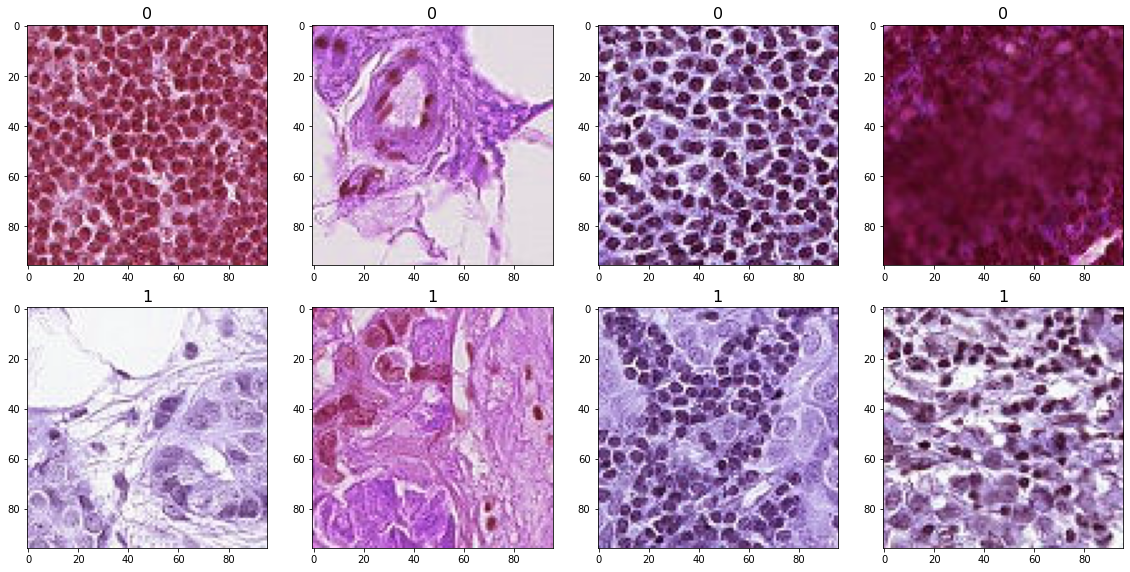

In [66]:
import cv2

IMAGE_PATH = '../input/histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

In [8]:
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000 
IMAGE_SIZE=96

In [9]:
df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [10]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160000 entries, 59145 to 44357
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      160000 non-null  object
 1   label   160000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [11]:
# Train Validation Split


df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=df_data['label'])

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [12]:
base_dir='base_dir'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [34]:
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

In [14]:
df_data.set_index('id', inplace=True)

In [15]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [35]:
print("Trainig Negative : "+str(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue'))))
print("Trainig Positive : "+str(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue'))))

print("Validation Negative : "+str(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue'))))
print("Validation Positive : "+str(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue'))))

Trainig Negative : 72000
Trainig Positive : 72000
Validation Negative : 8000
Validation Positive : 8000


In [17]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 8
val_batch_size = 8


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

print("Train Steps = " +str(train_steps))
print("Validation Steps = " +str(val_steps))


Train Steps = 18000.0
Validation Steps = 2000.0


In [18]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [30]:
kernel_size = (3,3)
pool_size= (2,2)

first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 41, 41, 64)       

In [31]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [32]:
savedModel = "Model.h5"
checkpoint = ModelCheckpoint(savedModel, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
18000/18000 [==============================] - 183s 10ms/step - loss: 0.4900 - accuracy: 0.7605 - val_loss: 0.4036 - val_accuracy: 0.8285
Epoch 2/20
18000/18000 [==============================] - 182s 10ms/step - loss: 0.3477 - accuracy: 0.8500 - val_loss: 0.3165 - val_accuracy: 0.8632
Epoch 3/20
18000/18000 [==============================] - 181s 10ms/step - loss: 0.2979 - accuracy: 0.8729 - val_loss: 0.2831 - val_accuracy: 0.8812
Epoch 4/20
18000/18000 [==============================] - 182s 10ms/step - loss: 0.2695 - accuracy: 0.8875 - val_loss: 0.2689 - val_accuracy: 0.8887
Epoch 5/20
18000/18000 [==============================] - 183s 10ms/step - loss: 0.2503 - accuracy: 0.8983 - val_loss: 0.2443 - val_accuracy: 0.9049
Epoch 6/20
18000/18000 [==============================] - 181s 10ms/step - loss: 0.2345 - accuracy: 0.9059 - val_loss: 0.2246 - val_accuracy: 0.9131
Epoch 7/20
18000/18000 [==============================] - 182s 10ms/step - loss: 0.2248 - accuracy: 0.9108

<Figure size 432x288 with 0 Axes>

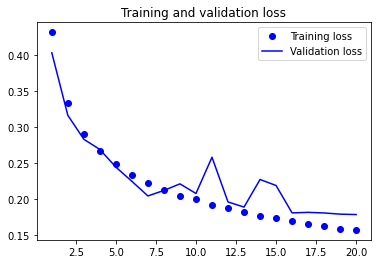

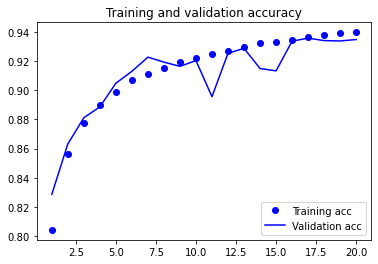

<Figure size 432x288 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [27]:
df_val

,id,label
56001,2ba8a23389f17c2a8a5b058a792f81f70380c214,0
28809,e5a1bd0126394fd82389afe1fc5f574c8e6c45d5,0
131354,d3a46fd1f45d0c9c77f53f842d1e6abc5c53e2fb,1
36584,5c3af1e5441262672faaff063e394f8b81939c69,0
106419,c154b575b4eda62597ff206e04d961041483ab52,1
...,...,...
28627,a96d694ab4724f5ca0f7c7ae56823ff851a99381,0
6446,76ab5b6b391e969919afb3ebee77693e9597127c,0
147054,ce04b2ef93935ef664952263ad62aa6fe787141d,1
38750,9977b7761f960a6b17cce34791a17373ae2461d3,0


In [37]:
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 16000 images belonging to 2 classes.


In [36]:
num_test_images = 16000
predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


16000/16000 [==============================] - 33s 2ms/step


In [38]:
predictions.shape

(16000, 2)

In [39]:
test_labels = test_gen.classes
assert(test_labels.shape == (16000,))

In [40]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [67]:
print(cm)

[[7386  614]
 [ 426 7574]]


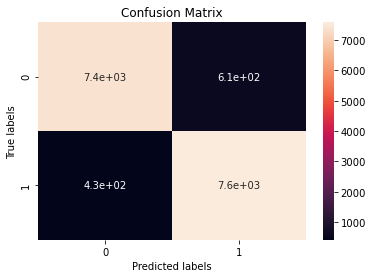

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [42]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.856599,1.434011e-01
1,1.000000,3.928896e-07
2,0.997669,2.330700e-03
3,1.000000,6.146468e-08
4,0.999967,3.339613e-05


In [43]:
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

In [49]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.9813819765624999

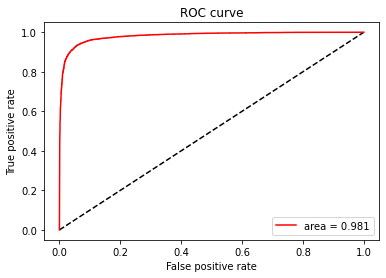

In [72]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras,'r', label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [56]:
from sklearn.metrics import classification_report

y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary)

print(report)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      8000
           1       0.93      0.95      0.94      8000

    accuracy                           0.94     16000
   macro avg       0.94      0.94      0.93     16000
weighted avg       0.94      0.94      0.93     16000

